# Case study: hydrogenation of HMF using single-atom Ni/CN catalysts

## Task summary

1. You can first build a simple kinetic model to simulate this reaction using a specific catalyst (Ni_2.1/CN). The kinetics can be first-order or second-order, so we only have one kinetic parameter to fit. You can use the data in Figure 2(a) (data also provided in the word document and highlighted in red) to build this model. You should see which model structure (first-order or second-order) fits the data better.

2.       If you find both models can fit data well equally (or similarly), you can then repeat the same approach to fit data in Figure 4 (d) using catalyst CN. The model that best fits the two catalysts should be used as the kinetic model in your work.

3.       Once you find the best model structure, you can move to Figure 6(a), where you calculate the reaction rate coefficient for all other catalysts. In this case, for each catalyst you only have one data point, but since you only have one parameter to fit (and the model structure has been verified), this will not be a problem.

4.       Once you have calculated all the kinetic parameters for all the catalysts, your next task is to do further literature review and try to collect as many molecular features or configuration features as possible for these catalysts. For example, if you see Figure 6 (also in Appendix), due to the change of Ni content, the binding energy, kinetic energy and charge density of these catalysts are all different. So we need to collect as many ‘features’ as possible.

5.       Once you have collected these features, we can use symbolic regression to automatically identify the most probably features and associated correlation to the kinetic rate coefficient. This will tell us what features are most important for the hydrogenation reaction and how to better design catalysts in future.

6.       It might be possible that we will extract some feature from spectra data (e.g. Figure 6). This will not be a problem (there are plenty of ML methods). For now, we don’t need to worry about this. We can discuss in due course once you’ve finished the first 4 steps.

In [1]:
#import some useful libraries
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import sklearn
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.utils.random import check_random_state
from mpl_toolkits.mplot3d import Axes3D

import pandas as pd
import numpy as np

from sympy import *
from sklearn.utils.random import check_random_state
import math
from sklearn.metrics import mean_squared_error, r2_score

from scipy.optimize import minimize


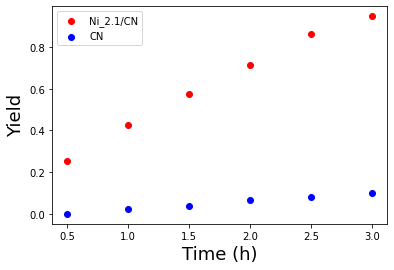

In [2]:
#Let's get some ideas from the original data set

time =  np.arange(0.5, 3.5, 0.5)
rxn_yield_Ni_21 = [25.2, 42.7, 57.3, 71.4, 86.3, 94.7]
rxn_yield_CN = [0, 2.2, 4, 6.6, 8.2, 9.8]

rxn_yield_Ni_21 = [ i/100 for i in rxn_yield_Ni_21]
rxn_yield_CN = [ i/100 for i in rxn_yield_CN]

plt.scatter(time, rxn_yield_Ni_21, c="r", label = "Ni_2.1/CN")
plt.scatter(time, rxn_yield_CN, c="b", label = "CN")
plt.legend()
plt.xlabel("Time (h)", fontsize=18)
plt.ylabel("Yield", fontsize=18)
#plt.legend(loc="upper left", fontsize=14)

plt.show()

In [3]:
#just a preference, persoanlly prefer using pandas
data_original = np.array([time, rxn_yield_Ni_21, rxn_yield_CN ]).T
columns = ['t', 'p_Ni2.1/CN', 'p_CN']
df_original = pd.DataFrame(data = data_original, columns = columns)
df_original

,t,p_Ni2.1/CN,p_CN
0,0.5,0.252,0.000
1,1.0,0.427,0.022
2,1.5,0.573,0.040
3,2.0,0.714,0.066
4,2.5,0.863,0.082
5,3.0,0.947,0.098


# Step 1 - building a kinetic model 
## 1.1 Journey to the 'best' k

By rearranging the integrated rate law, we get:

* First order: $[A]_{t} = [A]_{0}e^{-kt}$

* Second order: $\frac{1}{[A]_{t}} = \frac{1}{[A]_{0}} + kt$


$i.e. [A]_{t} = \frac{[A]_0}{1+kt[A]_0}$

where $[A]_{t}$ represents concentration at any time, $t$, $[A]_{0}$ stands for the initial concentration, and $k$ is the rate constant.

The product yield used in the paper was defined as follows:


* $\color{red}{\text{$Product\: yield  \:(p) = \frac{Moles\: of \: product}{Moles \: of \: HMF \: loaded   \: (reactant)} \times 100$% =   $\frac{[P]_{t}}{[A]_{0}}$}}  $


(https://doi.org/10.1021/acscatal.1c01386)


which is slightly different from the coventional definition of the percentage yield in chemistry... 


**N.B. we put the similar or equal sign here, assuming the evaporation of the ethanol won't place a big effect on the concentration.**

Now, from the product point of view, we can approximate the relationship between the product concentration and time: 

* First order: $[P]_{t} = [A]_{0}-[A]_{0}e^{-kt} =[A]_{0}(1-e^{-kt})$ 

* Second order: 

$[P]_{t} = [A]_{0} - (\frac{[A]_0}{1+kt[A]_0})$




* $[P]_{t,1st} = [A]_{0}Y(1-e^{-kt})$
* $[P]_{t,2nd} = \frac{Ykt[A]_0^2}{1+kt[A]_0}$ 

For now we just neglect the percentage yield $Y$.


* $[P]_{t,1st} = [A]_{0}(1-e^{-kt})$
* $[P]_{t,2nd} =  \frac{kt[A]_0^2}{1+kt[A]_0}$ 





`rate constant k for the first order kinetics`

$ \frac{[P]_{t,1st}}{[A]_{0}}= 1-e^{-kt}$ 

$ i.e. \: p = 1-e^{-kt}$ 

$e^{-kt} = 1 - p$


$-kt = \ln{(1-p)}$

$\therefore k = -\frac{\ln{(1-p)}}{t}$

`rate constant k for the second order kinetics` 

$[P]_{t,2nd} =  \frac{kt[A]_0^2}{1+kt[A]_0}$ 

$p = \frac{kt[A]_0}{1+kt[A]_0}$

$\frac{1}{p} = \frac{1+kt[A]_0}{kt[A]_0}$

Here, we just treat $[A]_0$ as a constant. As a result, we get:

$\frac{1}{p} = \frac{1+kt}{kt} = \frac{1}{kt}+1$

$\frac{1}{kt} = \frac{1}{p}-1$


$k = \frac{1}{\frac{(\frac{1}{p}-1)}   {t}}$

We now want to find the best rate constant that could fit our models nicely. To do so, we can compare the mean sqaure errors of theexperimental and predicted data.

In [4]:
def first_order_p(t):
    p_pred = 1-np.exp(- k*t) #predicting the yield
    return p_pred
def second_order_p(t):
    p_pred = (k*t)/(1+k*t) 
    return p_pred

def mse_first(k, t, Y):
    p_pred = first_order_p(k, t)
    mse = np.mean(((p_pred - Y) ** 2))
    return mse

def mse_second(k, t, Y):
    p_pred = second_order_p(k, t)
    mse = np.mean(((p_pred - Y) ** 2))
    return mse

### Finding the k value for the reaction catalysed by the Ni2.1/CN catalyst

In [5]:
#treating p as a function of k an
import numpy as np
from scipy.optimize import minimize

def first_order_p(k, t):
    p_pred = 1-np.exp(-k * t) #predicting the yield
    return p_pred

def second_order_p(k, t):
    p_pred = (k*t)/(1+k*t)
    return p_pred

def mse_first(k, t, Y):
    p_pred = first_order_p(k, t)
    mse = np.mean(((p_pred - Y) ** 2))
    return mse

def mse_second(k, t, Y):
    p_pred = second_order_p(k, t)
    mse = np.mean(((p_pred - Y) ** 2))
    return mse


In [6]:
# perform fit to find optimal parameters
# initial value for k (guess)
k = 0.6

res_1st = minimize(mse_first, k, args=(time, rxn_yield_Ni_21), tol=1e-3, method="BFGS",options={'disp':True})
print(res_1st)

k_opt_1st = res_1st.x[0]
print(f'rate constant: {k_opt_1st}')

Optimization terminated successfully.
         Current function value: 0.002910
         Iterations: 3
         Function evaluations: 8
         Gradient evaluations: 4
      fun: 0.002909619439037728
 hess_inv: array([[1.81161982]])
      jac: array([-5.88802795e-05])
  message: 'Optimization terminated successfully.'
     nfev: 8
      nit: 3
     njev: 4
   status: 0
  success: True
        x: array([0.64748942])
rate constant: 0.6474894168329061


In [7]:
## second order
res_2nd = minimize(mse_second, k, args=(time, rxn_yield_Ni_21) , tol=1e-3, method="BFGS",options={'disp':True})
print(res_2nd)
k_opt_2nd = res_2nd.x[0]
print(f'rate constant: {k_opt_2nd}')

Optimization terminated successfully.
         Current function value: 0.012022
         Iterations: 5
         Function evaluations: 12
         Gradient evaluations: 6
      fun: 0.01202221298148845
 hess_inv: array([[9.23975304]])
      jac: array([-0.00048564])
  message: 'Optimization terminated successfully.'
     nfev: 12
      nit: 5
     njev: 6
   status: 0
  success: True
        x: array([1.10735883])
rate constant: 1.1073588347331005


In [8]:
def first_order_yield(t):
    k = k_opt_1st
    p_pred = 1-np.exp(-k * t) #predicting the yield
    return p_pred

def second_order_yield(t):
    k = k_opt_2nd
    p_pred = (k*t)/(1+k*t)
    return p_pred


In [9]:
rxn_yield_1st_Ni_21 = []
rxn_yield_2nd_Ni_21 = []
for i in time:
    rxn_yield_1st_Ni_21.append(first_order_yield(i))
    rxn_yield_2nd_Ni_21.append(second_order_yield(i))

Text(0.5, 0, '$p 2nd order $')

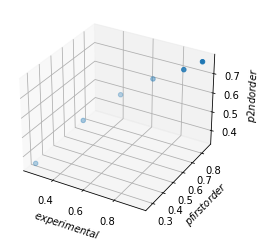

In [10]:
ax = plt.axes(projection='3d')
ax.scatter3D(df_original['p_Ni2.1/CN'], rxn_yield_1st_Ni_21, rxn_yield_2nd_Ni_21)
ax.set_xlabel('$experimental$', rotation=150)
ax.set_ylabel('$p first order$')
ax.set_zlabel('$p 2nd order $', rotation=60)

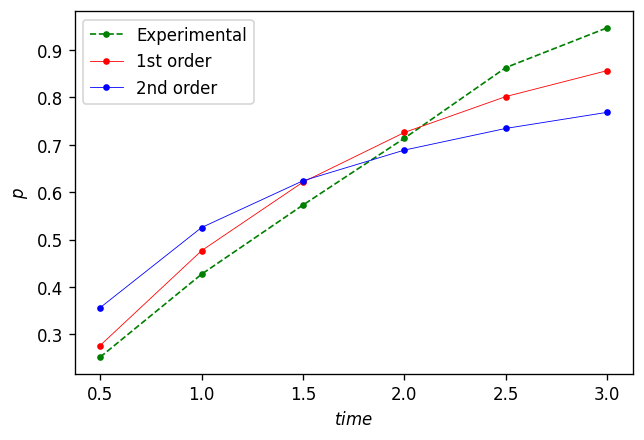

In [11]:
fig = plt.figure(constrained_layout=False, dpi=120)

plt.plot(time, df_original['p_Ni2.1/CN'], color='green', marker='o', linestyle='dashed',linewidth=1, markersize=3)
plt.plot(time, rxn_yield_1st_Ni_21, color='red', marker='o', linewidth=0.5, markersize=3)
plt.plot(time, rxn_yield_2nd_Ni_21, color='blue', marker='o', linewidth=0.5, markersize=3)

plt.legend(["Experimental", "1st order","2nd order"])

plt.xlabel('$time$')
plt.ylabel('$p$')
plt.show()

### Finding the k value for the reaction catalysed by the CN catalyst

In [12]:
# perform fit to find optimal parameters
# initial value for k (guess)
k = 0.6

res_1st = minimize(mse_first, k, args=(time, rxn_yield_CN), tol=1e-3, method="BFGS",options={'disp':True})
print(res_1st)

k_opt_1st = res_1st.x[0]
print(f'rate constant: {k_opt_1st}')

Optimization terminated successfully.
         Current function value: 0.000078
         Iterations: 4
         Function evaluations: 12
         Gradient evaluations: 6
      fun: 7.799591742611922e-05
 hess_inv: array([[0.15477166]])
      jac: array([-5.43017813e-06])
  message: 'Optimization terminated successfully.'
     nfev: 12
      nit: 4
     njev: 6
   status: 0
  success: True
        x: array([0.03251714])
rate constant: 0.032517138288027755


In [13]:
## second order
res_2nd = minimize(mse_second, k, args=(time, rxn_yield_CN) , tol=1e-3, method="BFGS",options={'disp':True})
print(res_2nd)
k_opt_2nd = res_2nd.x[0]
print(f'rate constant: {k_opt_2nd}' )

Optimization terminated successfully.
         Current function value: 0.000086
         Iterations: 4
         Function evaluations: 22
         Gradient evaluations: 11
      fun: 8.629495911712643e-05
 hess_inv: array([[0.17586383]])
      jac: array([0.00034989])
  message: 'Optimization terminated successfully.'
     nfev: 22
      nit: 4
     njev: 11
   status: 0
  success: True
        x: array([0.03379134])
rate constant: 0.03379134427538191


In [14]:

def first_order_p(t):
    k = k_opt_1st
    p_pred = 1-np.exp(-k * t) #predicting the yield
    return p_pred

def second_order_p(t):
    k = k_opt_2nd
    p_pred = (k*t)/(1+k*t)
    return p_pred

rxn_yield_1st_CN = []
rxn_yield_2nd_CN = []
for i in time:
    rxn_yield_1st_CN.append(first_order_p(i))
    rxn_yield_2nd_CN.append(second_order_p(i))

Text(0.5, 0, '$p_2nd order $')

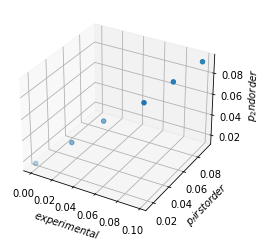

In [15]:
ax = plt.axes(projection='3d')
ax.scatter3D(df_original['p_CN'], rxn_yield_1st_CN, rxn_yield_2nd_CN)
ax.set_xlabel('$experimental$', rotation=150)
ax.set_ylabel('$p_first order$')
ax.set_zlabel('$p_2nd order $', rotation=60)

In [16]:
df_original['p_CN'].shape

(6,)

In [17]:
time.shape

(6,)

Text(0, 0.5, '$p$')

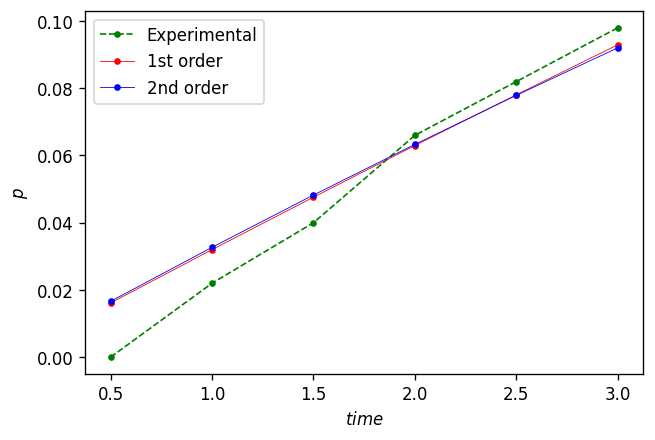

In [18]:
fig = plt.figure(constrained_layout=False, dpi=120)
plt.plot(time, df_original['p_CN'], color='green', marker='o', linestyle='dashed',linewidth=1, markersize=3)
plt.plot(time, rxn_yield_1st_CN, color='red', marker='o', linewidth=0.5, markersize=3)
plt.plot(time, rxn_yield_2nd_CN, color='blue', marker='o', linewidth=0.5, markersize=3)

plt.legend(["Experimental", "1st order","2nd order"])
plt.xlabel('$time$')
plt.ylabel('$p$')

# predicting k for other reactions

 
 $ k = -\frac{\ln{(1-p)}}{t}$

In [19]:
def rxn_coefficient(p, t):
    return -(np.log(1-p))/t

In [20]:
Ni_content = [0, 1.2, 2.1, 3.8, 10.1] 
N_content = [12.1, 8.6, 9.94, 9.97, 1.96] 
Ni_chi = [1.91, 1.91, 1.91, 1.91, 1.91]
N_chi = [3.04, 3.04, 3.04, 3.04, 3.04]

yield_3hr = [4, 32, 94.7, 94.4, 12]
yield_3hr = [ i/100 for i in yield_3hr]

k_5_cat = []
for i in yield_3hr:
    k_5_cat.append(rxn_coefficient(i,3))
print(list(zip(Ni_content,k_5_cat)))

[(0, 0.013607331506751722), (1.2, 0.1285541602706616), (2.1, 0.9791544551433389), (3.8, 0.9608011960823296), (10.1, 0.042611123836628295)]


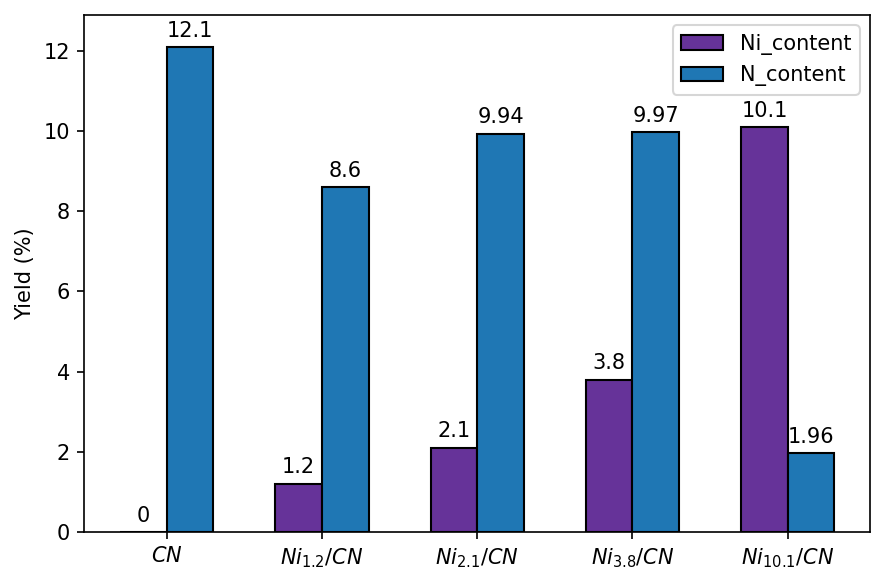

In [21]:

# importing package
import matplotlib.pyplot as plt
import numpy as np
labels = ['$CN$', '$Ni_{1.2}/CN$','$Ni_{2.1}/CN$', '$Ni_{3.8}/CN$', '$Ni_{10.1}/CN$']
Ni_content = [0, 1.2, 2.1, 3.8, 10.1] 
N_content = [12.1, 8.6, 9.94, 9.97, 1.96]

x = np.arange(5)  # the label locations
width = 0.30  # the width of the bars


fig, ax = plt.subplots(1,1,  dpi=150)
tr_error = ax.bar(x - width/2, Ni_content, width, color = 'rebeccapurple', edgecolor= 'black', label='Ni_content')
te_error = ax.bar(x + width/2, N_content, width,edgecolor= 'black',  label='N_content')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Yield (%)')
ax.set_ylim(0,12.9)
ax.set_aspect('auto')
#ax.set_xticks(x, labels)
ax.set_xticks( x, ['$CN$', '$Ni_{1.2}/CN$','$Ni_{2.1}/CN$', '$Ni_{3.8}/CN$', '$Ni_{10.1}/CN$'])

ax.legend(loc=1)

ax.bar_label(tr_error,  padding=3)
ax.bar_label(te_error,  padding=3)

fig.tight_layout()

plt.show()

# Molecular features for these catalysts

* electron dissipation >>> large amount of metal Ni nanoparticles resulted in a decrease in binding energy (Ni10.1/CN)
 (atomic-level dispersion of active sites)
* Brunauer−Emmett−Teller (BET) surface area 
* binding energy

Based on the above results, it can be concluded that Nix/CN catalysts with the high density of single Ni−N4 sites promoted the electron dissipation of its coordinated pyridinic N, reduced the affinity of the H radical, and facilitated the TH process.

In [22]:
def BE_est(WF):
    KE = 1084
    hv = 1486.8
    return -KE + hv - WF

In [23]:
BE = []
WF = [4.59, 4.24, 4.16, 4.17, 4.27]
for i in WF:
    BE.append(BE_est(i))
BE

[398.21, 398.55999999999995, 398.63999999999993, 398.62999999999994, 398.53]

Once you have collected these features, we can use symbolic regression to automatically identify the most probably features and associated correlation to the kinetic rate coefficient. This will tell us what features are most important for the hydrogenation reaction and how to better design catalysts in future.

# Descriptors
Once you have collected these features, we can use symbolic regression to automatically identify the most probably features and associated correlation to the kinetic rate coefficient. This will tell us what features are most important for the hydrogenation reaction and how to better design catalysts in future.

In [24]:
Ni_and_yield = np.array([Ni_content, yield_3hr, k_5_cat]).T
columns_Ni = ['Ni_content', 'p_3hr', 'k']
df_diff_Ni_cont = pd.DataFrame(data = Ni_and_yield, columns = columns_Ni)
df_diff_Ni_cont

,Ni_content,p_3hr,k
0,0.0,0.040,0.013607
1,1.2,0.320,0.128554
2,2.1,0.947,0.979154
3,3.8,0.944,0.960801
4,10.1,0.120,0.042611


## Input features

In [25]:
Ni_and_yield = np.array([Ni_content,  N_content, Ni_chi, N_chi, k_5_cat, BE]).T
columns_Ni = ['Ni_content', 'N_content', 'Ni_chi', 'N_chi','k', 'estimated_binding_energy' ]
df_diff_Ni_cont = pd.DataFrame(data = Ni_and_yield, columns = columns_Ni)
df_diff_Ni_cont

,Ni_content,N_content,Ni_chi,N_chi,k,estimated_binding_energy
0,0.0,12.10,1.91,3.04,0.013607,398.21
1,1.2,8.60,1.91,3.04,0.128554,398.56
2,2.1,9.94,1.91,3.04,0.979154,398.64
3,3.8,9.97,1.91,3.04,0.960801,398.63
4,10.1,1.96,1.91,3.04,0.042611,398.53


In [26]:
X_raw = df_diff_Ni_cont[['Ni_content', 'N_content', 'Ni_chi', 'N_chi','estimated_binding_energy']].to_numpy() 
y = df_diff_Ni_cont[['k']].to_numpy()

# ML

In [27]:
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(X_raw, y, test_size=0.40, random_state=0)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((3, 5), (2, 5), (3, 1), (2, 1))

In [28]:
y

array([[0.01360733],
       [0.12855416],
       [0.97915446],
       [0.9608012 ],
       [0.04261112]])

In [29]:
y_train

array([[0.12855416],
       [0.9608012 ],
       [0.04261112]])

In [30]:
X_train.shape

(3, 5)

In [31]:
X_train

array([[  1.2 ,   8.6 ,   1.91,   3.04, 398.56],
       [  3.8 ,   9.97,   1.91,   3.04, 398.63],
       [ 10.1 ,   1.96,   1.91,   3.04, 398.53]])

In [32]:
y_train

array([[0.12855416],
       [0.9608012 ],
       [0.04261112]])

In [33]:
np.ravel(y_train)

array([0.12855416, 0.9608012 , 0.04261112])

# Ridge Regression

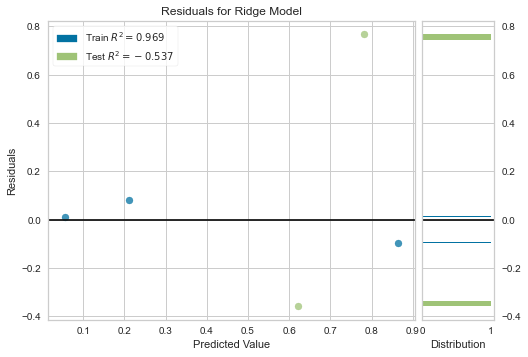

<AxesSubplot:title={'center':'Residuals for Ridge Model'}, xlabel='Predicted Value', ylabel='Residuals'>

In [34]:
from sklearn.linear_model import Ridge
from sklearn.model_selection import train_test_split

from yellowbrick.datasets import load_concrete
from yellowbrick.regressor import ResidualsPlot


# Instantiate the linear model and visualizer
model_ridge = Ridge()
visualizer = ResidualsPlot(model_ridge)

visualizer.fit(X_train, y_train)  # Fit the training data to the visualizer
visualizer.score(X_test, y_test)  # Evaluate the model on the test data
visualizer.show()                 # Finalize and render the figure

In [35]:
y_train_ridge = model_ridge.predict(X_train)
y_test_ridge = model_ridge.predict(X_test)

In [36]:
#Root mean square error.
tr_rmse = math.sqrt(mean_squared_error(y_train_ridge,y_train))
te_rmse = math.sqrt(mean_squared_error(y_test_ridge,y_test))
print("Root mean square error (RMSE):")
print("Training Set: {:.3f} ".format(tr_rmse))
print("Test Set: {:.3f} ".format(te_rmse))


Root mean square error (RMSE):
Training Set: 0.073 
Test Set: 0.598 


# Random Forest 

In [38]:
# Grid search - tuning hyperparameters of the random forest classifier
rndfor_rdkit = RandomForestRegressor(random_state = 42)
rndfor_rdkit.fit(X_raw, y)


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  This is separate from the ipykernel package so we can avoid doing imports until


RandomForestRegressor(random_state=42)

In [39]:
#Hyperparameter Grid 
parameter_grid = {'max_depth':[2, 10, 50, 100],
'n_estimators':[10, 50, 100, 250]}

#Cross-Validated Grid Search
#we're now ready to create our grid-search object. We'll use each the objects we've created thus far.
from sklearn.model_selection import GridSearchCV

grid_search = GridSearchCV(cv=3,
estimator=rndfor_rdkit ,
param_grid=parameter_grid )

In [40]:
#fit the model
grid_search.fit(X_raw, y)


/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_regression.py:796: UndefinedMetricWarning: R^2 score is not well-defin

GridSearchCV(cv=3, estimator=RandomForestRegressor(random_state=42),
             param_grid={'max_depth': [2, 10, 50, 100],
                         'n_estimators': [10, 50, 100, 250]})

In [41]:
# Visualise the accuracy score
pd.DataFrame(grid_search.cv_results_)


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
0,0.013683,0.004787,0.001797,0.000572,2,10,"{'max_depth': 2, 'n_estimators': 10}",-152.503771,-9050.433606,NaN,NaN,NaN,1
1,0.045389,0.006832,0.003498,0.000036,2,50,"{'max_depth': 2, 'n_estimators': 50}",-130.330397,-9133.930002,NaN,NaN,NaN,2
2,0.084616,0.004621,0.006681,0.000212,2,100,"{'max_depth': 2, 'n_estimators': 100}",-137.612281,-9128.112157,NaN,NaN,NaN,3
3,0.222560,0.015703,0.016071,0.000346,2,250,"{'max_depth': 2, 'n_estimators': 250}",-146.766241,-9005.229667,NaN,NaN,NaN,4
4,0.012918,0.002460,0.001360,0.000195,10,10,"{'max_depth': 10, 'n_estimators': 10}",-152.503771,-9050.433606,NaN,NaN,NaN,5
5,0.045045,0.002238,0.003772,0.000372,10,50,"{'max_depth': 10, 'n_estimators': 50}",-130.330397,-9133.930002,NaN,NaN,NaN,6
6,0.083389,0.003867,0.006485,0.000048,10,100,"{'max_depth': 10, 'n_estimators': 100}",-137.612281,-9128.112157,NaN,NaN,NaN,7
7,0.214946,0.011613,0.016349,0.000581,10,250,"{'max_depth': 10, 'n_estimators': 250}",-146.766241,-9005.229667,NaN,NaN,NaN,8
8,0.009604,0.000589,0.001252,0.000076,50,10,"{'max_depth': 50, 'n_estimators': 10}",-152.503771,-9050.433606,NaN,NaN,NaN,9
9,0.048208,0.003958,0.003676,0.000121,50,50,"{'max_depth': 50, 'n_estimators': 50}",-130.330397,-9133.930002,NaN,NaN,NaN,10


In [42]:
print(grid_search.best_params_)
print(grid_search.best_score_)

{'max_depth': 2, 'n_estimators': 10}
nan


In [43]:
# From the cell above we decided to use max_depth: 2 and  n_estimators: 10

rndfor_rd = RandomForestRegressor(n_estimators=2, max_depth = 10)
rndfor_rd.fit(X_raw, y)

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  after removing the cwd from sys.path.


RandomForestRegressor(max_depth=10, n_estimators=2)

In [44]:
X_raw = df_diff_Ni_cont[['Ni_content', 'N_content', 'Ni_chi', 'N_chi','estimated_binding_energy']].to_numpy() 
y = df_diff_Ni_cont[['k']].to_numpy()

In [45]:
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(X_raw, y, test_size=0.40, random_state=0)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((3, 5), (2, 5), (3, 1), (2, 1))

In [46]:
# From the cell above we decided to use max_depth: 10 and  n_estimators: 2

rndfor_rd = RandomForestRegressor(n_estimators=2, max_depth = 10)
rndfor_rd.fit(X_raw, y)

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  after removing the cwd from sys.path.


RandomForestRegressor(max_depth=10, n_estimators=2)

In [47]:
y_rndfor_train = rndfor_rd.predict(X_train)
y_rndfor_test  = rndfor_rd.predict(X_test)

In [48]:
import math
from sklearn.metrics import  mean_squared_error


#Root mean square error.
tr_rmse = math.sqrt(mean_squared_error(y_train, y_rndfor_train))
te_rmse = math.sqrt(mean_squared_error(y_test,y_rndfor_test))

print("Root mean square error (RMSE):")
print("Training Set: {:.3f} ".format(tr_rmse))
print("Test Set: {:.3f} ".format(te_rmse))


Root mean square error (RMSE):
Training Set: 0.242 
Test Set: 0.454 


# PySR

In [49]:
#model.reset()

In [50]:
from pysr import PySRRegressor
model = PySRRegressor(
    population_size=100,
    niterations=100,
 
    binary_operators=["+", "*", "-", "/"],
    unary_operators=[  "neg", "square", "cube",# Custom operator (julia syntax)
    ],
    model_selection="best",
    denoise = True,
    annealing = True,

)

In [51]:
model.fit(X_train, np.ravel(y_train))

/opt/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/kernels.py:437: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  ConvergenceWarning,
/opt/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/kernels.py:437: ConvergenceWarning: The optimal value found for dimension 1 of parameter k1__k1__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  ConvergenceWarning,
/opt/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/kernels.py:427: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  ConvergenceWarning,
/opt/anaconda3/lib/python3.7/site-packages/sklearn/gauss

Started!

Cycles per second: 9.270e+04
Head worker occupation: 14.0%
Progress: 85 / 1500 total iterations (5.667%)
Hall of Fame:
-----------------------------------------
Complexity  loss       Score     Equation
1           1.714e-01  1.737e-07  0.3773184
3           9.569e-02  2.916e-01  (x1 * 0.060768683)
4           7.383e-02  2.593e-01  square(x1 * 0.08272306)
5           5.738e-02  2.522e-01  ((x1 * 0.01994586) * x0)
6           3.940e-03  2.678e+00  (square(x1 * 0.04972336) * x0)
8           4.635e-04  1.070e+00  ((square(x1 * 0.052599672) * x0) + -0.08893194)
10          2.542e-04  3.004e-01  ((square(x1 * 0.053037096) * (x0 - 0.08507677)) - 0.08507677)
11          2.341e-04  8.246e-02  ((square(neg(x1) * -0.053105775) * (x0 + -0.09150429)) - 0.0839751)
12          2.656e-05  2.176e+00  cube(square(square((x1 * -0.2929817) / x3)) + (x0 * 0.035535876))
14          2.045e-05  1.308e-01  cube(square(square((x1 * -0.29294512) / x3)) + ((x0 * 0.035816383) - 0.0021672852))
16        

PySRRegressor.equations = [
	   pick      score                                           equation  \
	0         0.000000                                          0.3773184   
	1         0.291584                                 (x1 * 0.060768683)   
	2         0.445664                              cube(x1 * 0.09455872)   
	3         0.665115                      square(cube(x1 * 0.09455872))   
	4         2.079176                     (square(x1 * 0.04972457) * x0)   
	5         1.368173             (square(square(x1 * 0.07100251)) * x0)   
	6         0.772023     ((square(x1 * 0.05260515) * x0) + -0.08875278)   
	7  >>>>  10.227129  ((x1 * (neg(x1 * -0.074216) + -0.770766)) - -1...   
	8         3.762849  ((square(x1) * (neg(x1 * -0.0063105715) + -0.0...   
	9         0.057201  ((square(x1 + cube(-0.006310575)) * (neg(x1 * ...   
	
	           loss  complexity  
	0  1.714437e-01           1  
	1  9.568739e-02           3  
	2  6.127808e-02           4  
	3  3.151006e-02           5  
	

In [52]:
print(model)

PySRRegressor.equations = [
	   pick      score                                           equation  \
	0         0.000000                                          0.3773184   
	1         0.291584                                 (x1 * 0.060768683)   
	2         0.445664                              cube(x1 * 0.09455872)   
	3         0.665115                      square(cube(x1 * 0.09455872))   
	4         2.079176                     (square(x1 * 0.04972457) * x0)   
	5         1.368173             (square(square(x1 * 0.07100251)) * x0)   
	6         0.772023     ((square(x1 * 0.05260515) * x0) + -0.08875278)   
	7  >>>>  10.227129  ((x1 * (neg(x1 * -0.074216) + -0.770766)) - -1...   
	8         3.762849  ((square(x1) * (neg(x1 * -0.0063105715) + -0.0...   
	9         0.057201  ((square(x1 + cube(-0.006310575)) * (neg(x1 * ...   
	
	           loss  complexity  
	0  1.714437e-01           1  
	1  9.568739e-02           3  
	2  6.127808e-02           4  
	3  3.151006e-02           5  
	

In [53]:
model.sympy()

x1*(0.074216*x1 - 0.770766) + 1.2681733

In [54]:
equations = model.equations["equation"]

In [55]:
legends = []
for i in equations:
    legends.append(i)
legends

['0.3773184',
 '(x1 * 0.060768683)',
 'cube(x1 * 0.09455872)',
 'square(cube(x1 * 0.09455872))',
 '(square(x1 * 0.04972457) * x0)',
 '(square(square(x1 * 0.07100251)) * x0)',
 '((square(x1 * 0.05260515) * x0) + -0.08875278)',
 '((x1 * (neg(x1 * -0.074216) + -0.770766)) - -1.2681733)',
 '((square(x1) * (neg(x1 * -0.0063105715) + -0.055339847)) - -0.20765819)',
 '((square(x1 + cube(-0.006310575)) * (neg(x1 * -0.0063105715) + -0.055339847)) - -0.20765819)']

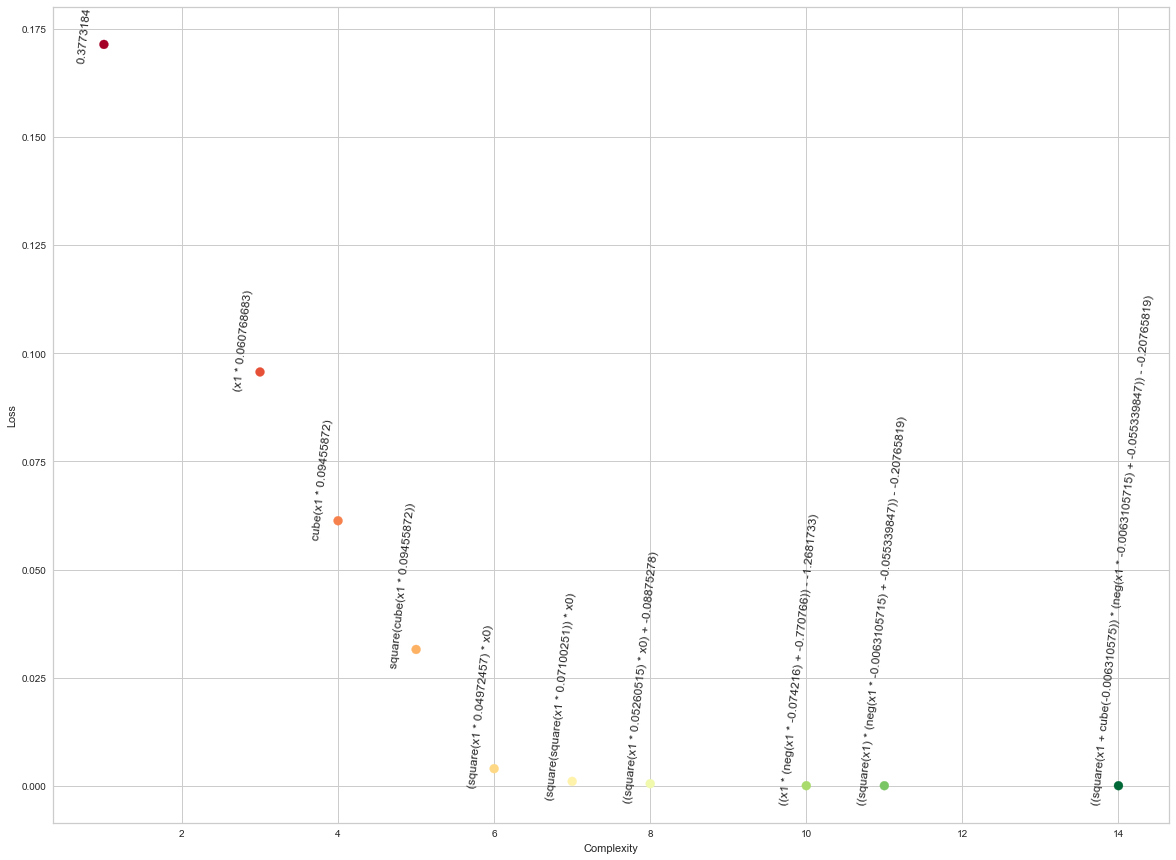

In [56]:
legends = []
for i in equations:
    legends.append(i)
    
X = model.equations["complexity"]
Y = model.equations["loss"]
equations = model.equations["equation"].tolist()
plt.figure(figsize=(20,15))
p = plt.scatter(X,Y,s=80,c= X, cmap="RdYlGn")
plt.xlabel("Complexity")
plt.ylabel("Loss")
#plt.xlim([0, 28])
#plt.ylim([0,0.00001])


for i, label in enumerate(equations):
    plt.annotate(label, (X[i]-0.35, Y[i]-0.004)).set_rotation(84)

    
plt.savefig('PF_TH.png', dpi=fig.dpi)

In [57]:
model.sympy()

x1*(0.074216*x1 - 0.770766) + 1.2681733

In [58]:
y_pysr_train_1 = model.set_params(extra_sympy_mappings={'inv': lambda x: 1 / x, 'exp': lambda x:  x**0.5 }).predict(X_train)
y_pysr_test_1  = model.set_params(extra_sympy_mappings={'inv': lambda x: 1 / x, 'exp': lambda x:  x**0.5 }).predict(X_test)

In [59]:
y_pysr_train_1, y_pysr_test_1


(array([0.12860106, 0.96077347, 0.04258013]), array([0.93956724, 2.80786926]))

In [60]:

import math
from sklearn.metrics import  mean_squared_error
#Root mean square error.
tr_rmse = math.sqrt(mean_squared_error(y_train, y_pysr_train_1))
te_rmse = math.sqrt(mean_squared_error(y_test,y_pysr_test_1))
print("Root mean square error (RMSE):")
print("Training Set: {:.3f} ".format(tr_rmse))
print("Test Set: {:.3f} ".format(te_rmse))


Root mean square error (RMSE):
Training Set: 0.000 
Test Set: 1.976 


In [61]:
#mean absolute error. 
from sklearn.metrics import  mean_absolute_error
tr_mae = mean_absolute_error(y_pysr_train_1,y_train )
te_mae =  mean_absolute_error(y_pysr_test_1,y_test)
print("Mean absolute error (MAE):")
print("Training Set: {:.3f} ".format(tr_mae))
print("Test Set: {:.3f} ".format(te_mae))

Mean absolute error (MAE):
Training Set: 0.000 
Test Set: 1.417 


In [62]:
#R2 scores
from sklearn.metrics import r2_score
tr_r2 = r2_score(y_train, y_pysr_train_1)
te_r2 = r2_score(y_test, y_pysr_test_1)
print("R2 Scores:")
print("Training Set: {:.3f} ".format(tr_r2))
print("Test Set: {:.3f} ".format(te_r2))

R2 Scores:
Training Set: 1.000 
Test Set: -15.753 


['$Training \\: set$', '$Test Set$']


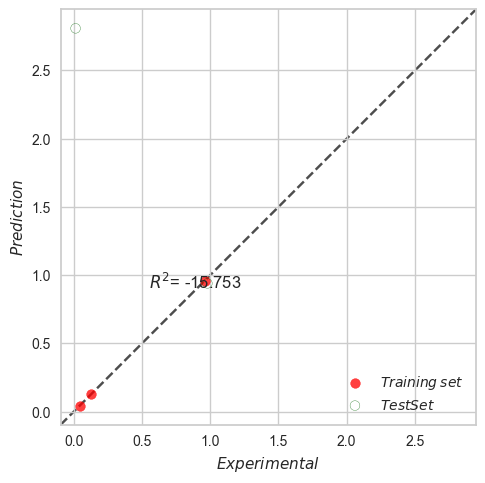

In [63]:
fig, ax = plt.subplots(1,1,  dpi=100)
ax.scatter(y_train, y_pysr_train_1,color='red',alpha=0.75,label='$Training \: set$')
ax.scatter(y_test, y_pysr_test_1,color='darkgreen',alpha=0.75,label='$Test Set$',facecolors='none')

# Find limits for each axes 
lims = [np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
        np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
       ]

ax.plot(lims, lims, 'k--', alpha=0.75, zorder=0)
ax.set_aspect('equal')

ax.set_xlim(lims)
ax.set_ylim(lims)

ax.set_xlabel('$Experimental$')
ax.set_ylabel('$Prediction$')

ax.annotate('$R^{2}$'+ '= {:.3f}'.format(r2_score(y_test, y_pysr_test_1)), (0.55,0.9))
handles, labels = ax.get_legend_handles_labels()
print(labels)
ax.legend(handles=handles, labels=labels)


# Feyn

In [64]:
import feyn

ql = feyn.QLattice()

This version of feyn and the QLattice is available for academic, personal, and non-commercial use. By using the community version of this software you agree to the terms and conditions which can be found at `https://abzu.ai/privacy`.


In [65]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(df_diff_Ni_cont, test_size=0.4, random_state=0)

train, test

(   Ni_content  N_content  Ni_chi  N_chi         k  estimated_binding_energy
 1         1.2       8.60    1.91   3.04  0.128554                    398.56
 3         3.8       9.97    1.91   3.04  0.960801                    398.63
 4        10.1       1.96    1.91   3.04  0.042611                    398.53,
    Ni_content  N_content  Ni_chi  N_chi         k  estimated_binding_energy
 2         2.1       9.94    1.91   3.04  0.979154                    398.64
 0         0.0      12.10    1.91   3.04  0.013607                    398.21)

In [66]:
# Sample and fit models
models = ql.auto_run(
    data=train,
    kind = "regression",
    output_name='k'
)



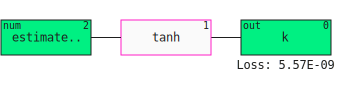

In [67]:
models[0]

In [68]:
models[0].sympify()

0.501836 - 0.462874*tanh(21913.2 - 54.9782*estimatedbindingenergy)

<?xml version="1.0" encoding="utf-8" ?>
<svg baseProfile="full" height="140.0" preserveAspectRatio="none" version="1.1" viewBox="0 0 635 140.0" width="635" xmlns="http://www.w3.org/2000/svg" xmlns:ev="http://www.w3.org/2001/xml-events" xmlns:xlink="http://www.w3.org/1999/xlink"><defs /><svg class="graph" height="95.0" width="351" x="0" y="0"><defs /><rect class="node" fill="#00F082" height="35" stroke="#1E1E1E" stroke-width="1" width="90" x="241" y="20.0"><title>k
linear:
scale=0.459095
scale offset=0.000000
w=-1.008231
bias=1.0931</title></rect><text fill="#1E1E1E" font-family="monospace" font-size="12" style="pointer-events:none" text-anchor="middle" x="286.0" y="41.5">k</text><text fill="#1E1E1E" font-family="monospace" font-size="10" style="pointer-events:none" text-anchor="end" x="329" y="29.0">0</text><text fill="#1E1E1E" font-family="monospace" font-size="10" style="pointer-events:none" text-anchor="start" x="243" y="29.0">out</text><line stroke="#1E1E1E" x1="211" x2="241" y1="37.5" y2="37.5" /><rect class="node" fill="#FAFAFA" height="35" stroke="#FF1EC8" stroke-width="1" width="90" x="121" y="20.0"><title>tanh</title></rect><text fill="#1E1E1E" font-family="monospace" font-size="12" style="pointer-events:none" text-anchor="middle" x="166.0" y="41.5">tanh</text><text fill="#1E1E1E" font-family="monospace" font-size="10" style="pointer-events:none" text-anchor="end" x="209" y="29.0">1</text><line stroke="#1E1E1E" x1="91" x2="121" y1="37.5" y2="37.5" /><rect class="node" fill="#00F082" height="35" stroke="#1E1E1E" stroke-width="1" width="90" x="1" y="20.0"><title>estimated_binding_energy
linear:
scale=20.000000
scale offset=398.573333
w=-2.748912
bias=0.3837</title></rect><text fill="#1E1E1E" font-family="monospace" font-size="12" style="pointer-events:none" text-anchor="middle" x="46.0" y="41.5">estimate..</text><text fill="#1E1E1E" font-family="monospace" font-size="10" style="pointer-events:none" text-anchor="end" x="89" y="29.0">2</text><text fill="#1E1E1E" font-family="monospace" font-size="10" style="pointer-events:none" text-anchor="start" x="3" y="29.0">num</text></svg><svg class="summary" height="64" width="180" x="351" y="0"><defs /><text fill="#1E1E1E" font-family="monospace" font-size="14" text-anchor="start" x="0" y="14">Training Metrics</text><line stroke="#1E1E1E" x1="0" x2="160" y1="19" y2="19" /><text fill="#1E1E1E" font-family="monospace" font-size="14" text-anchor="start" x="5" y="34">R2</text><text fill="#1E1E1E" font-family="monospace" font-size="14" text-anchor="end" x="155" y="34">1.0</text><text fill="#1E1E1E" font-family="monospace" font-size="14" text-anchor="start" x="5" y="49">RMSE</text><text fill="#1E1E1E" font-family="monospace" font-size="14" text-anchor="end" x="155" y="49">6.14e-07</text><text fill="#1E1E1E" font-family="monospace" font-size="14" text-anchor="start" x="5" y="64">MAE</text><text fill="#1E1E1E" font-family="monospace" font-size="14" text-anchor="end" x="155" y="64">5.61e-07</text></svg><svg class="summary" height="64" width="104" x="531" y="0"><defs /><text fill="#1E1E1E" font-family="monospace" font-size="14" text-anchor="start" x="0" y="14">Test</text><line stroke="#1E1E1E" x1="0" x2="84" y1="19" y2="19" /><text fill="#1E1E1E" font-family="monospace" font-size="14" text-anchor="end" x="79" y="34">0.998</text><text fill="#1E1E1E" font-family="monospace" font-size="14" text-anchor="end" x="79" y="49">0.0211</text><text fill="#1E1E1E" font-family="monospace" font-size="14" text-anchor="end" x="79" y="64">0.0206</text></svg><svg class="h_space" height="19" width="50" x="0" y="95.0"><defs /><text fill="#1E1E1E" font-family="monospace" font-size="14" text-anchor="start" x="0" y="14">Inputs</text><line stroke="#1E1E1E" x1="0" x2="50" y1="19" y2="19" /></svg><svg class="table" height="21" width="193" x="0" y="114.0"><defs /><text fill="#1E1E1E" font-family="monospace" font-size="12" text-anchor="start" x="5" y="16"><tspan font-weight="bold">estimate</tspan><tspan>d_binding_energ
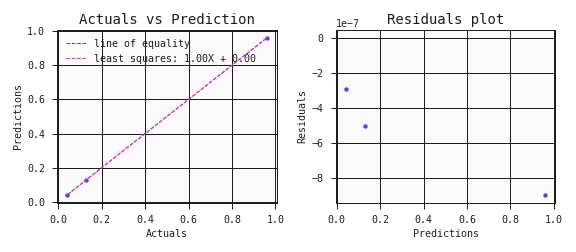
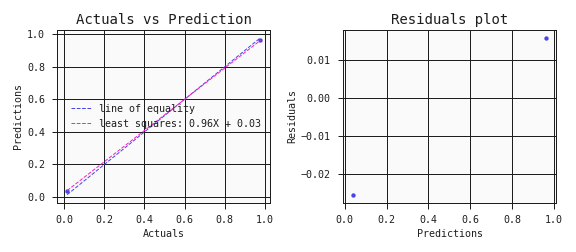

In [69]:
# Select the best Model
best = models[0]
best.plot(
    data=train,
    compare_data=test
)

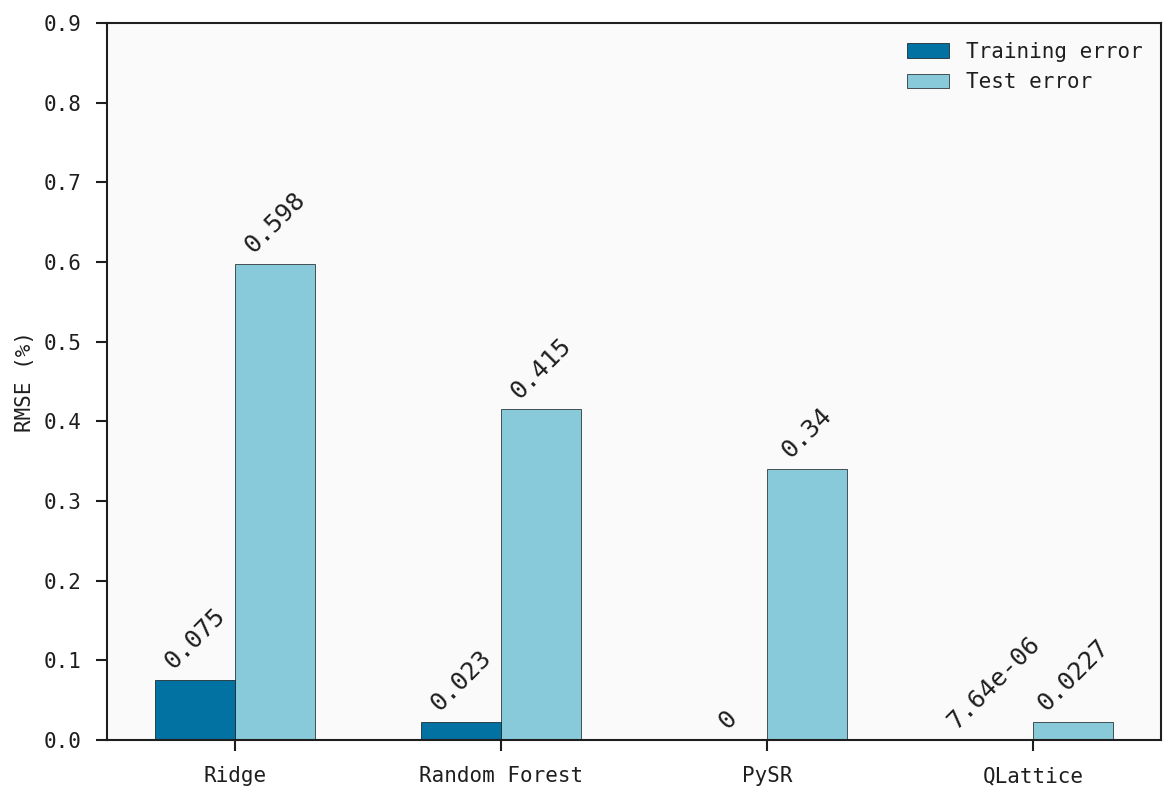

In [72]:

labels = ['Ridge', 'Random Forest','PySR', 'QLattice']
tr_rmse = [0.075,0.023, 0.000, 0.00000764]
te_rmse = [0.598, 0.415, 0.340, 0.0227]

x = np.arange(4)  # the label locations
width = 0.30  # the width of the bars


fig, ax = plt.subplots(1,1,  dpi=150)
tr_error = ax.bar(x - width/2, tr_rmse, width, label='Training error', color = "b", edgecolor= 'black')
te_error = ax.bar(x + width/2, te_rmse, width, label='Test error', color = "c", edgecolor= 'black')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('RMSE (%)')
ax.set_aspect('auto')
ax.set_ylim(0,0.9)
#ax.set_xticks(x, labels)
ax.set_xticks( x, ['Ridge', 'Random Forest','PySR', 'QLattice'])

ax.legend(loc=1)

ax.bar_label(tr_error, rotation=45, padding=3)
ax.bar_label(te_error, rotation=45, padding=3)
plt.grid(visible=None)

fig.tight_layout()

